# **MEGALINE - ANÁLISIS DE RENTABILIDAD**

**Megaline**, un operador de telecomunicaciones, ofrece dos tarifas de prepago: *Surf* y *Ultimate*. El departamento comercial necesita ajustar su presupuesto de publicidad y, para ello, requiere determinar **cuál de los dos planes genera mayor rentabilidad promedio por usuario**.

Este análisis utiliza una muestra representativa de 500 clientes durante el año 2018 para evaluar el comportamiento de consumo (llamadas, mensajería y datos) y validar estadísticamente qué tarifa es más beneficiosa para la empresa.

### Objetivos Específicos
1. **Ingeniería de Datos:** Depurar y transformar los datos crudos, aplicando las reglas de negocio específicas de Megaline (redondeo de minutos y megabytes).
2. **Análisis Exploratorio (EDA):** Identificar patrones de comportamiento en los usuarios de cada plan.
3. **Evaluación Financiera:** Calcular ingresos mensuales por usuario y realizar pruebas de hipótesis para determinar diferencias significativas entre los planes y regiones (NY-NJ vs. Resto).

---

## **Descripción de los Datos**
Trabajaré con 5 tablas interconectadas que representan el ciclo de vida del usuario:

* **`users`**: Perfil demográfico (id, nombre, edad, ciudad, tarifa, fecha de alta/baja).
* **`calls`**: Registro detallado de llamadas (duración y fecha).
* **`messages`**: Registro de SMS enviados.
* **`internet`**: Registro de sesiones web y volumen de datos (MB).
* **`plans`**: Parámetros de facturación y límites de cada tarifa.

---

## **Metodología de Trabajo (Pipeline)**
Seguiré un flujo de trabajo estructurado con cinco etapas clave para garantizar la integridad de los datos y la reproducibilidad de los resultados:

1. **Ingesta y Validación**: Configuración del entorno y carga inicial de los datos en su formato crudo para asegurar que la información esté completa y accesible.
2. **Preprocesamiento y Normalización**: Revisión sistemática de cada tabla por separado (usuarios, llamadas, internet, etc.) para diagnosticar problemas de tipos o valores ausentes y aplicar correcciones específicas antes de cualquier agregación.
3. **Agregación y Enriquecimiento (ABT)**: Transformación de los registros limpios en métricas mensuales y fusión de todas las tablas en una **Tabla Base Analítica** unificada, aplicando las reglas de negocio de Megaline para el cálculo de ingresos.
4. **Análisis Exploratorio de Datos (EDA)**: Diagnóstico visual de la información para identificar patrones críticos, tendencias de consumo y posibles anomalías en los segmentos.
5. **Pruebas de Hipótesis**: Validación estadística de las premisas de negocio para garantizar que las conclusiones sobre rentabilidad sean sólidas y accionables.

---

## 1. Ingesta de Datos y Validación Técnica

Comenzaré configurando el entorno de trabajo y cargando los datos tal como se reciben de la fuente. 

En esta fase preliminar, no alteraremos el contenido. El objetivo es realizar una **carga aséptica** y un diagnóstico estructural rápido para confirmar que los cinco conjuntos de datos se han leído correctamente y están listos para ser auditados individualmente en la siguiente etapa.

In [1]:
# Importación de las lñibrerías necesarias para el análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# Configuración visual
sns.set_theme(style="whitegrid", palette="muted")
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Cargamos los datasets objeto de análisis (con manejo de fechas optimizado "parse_dates")
try:
    print('Cargado datasets...')
    calls_df = pd.read_csv("../data/megaline_calls.csv")
    internet_df = pd.read_csv("../data/megaline_internet.csv")
    messages_df = pd.read_csv("../data/megaline_messages.csv")
    plans_df = pd.read_csv("../data/megaline_plans.csv")
    users_df = pd.read_csv("../data/megaline_users.csv")
    print('Datos cargados exitosamente.')
except FileNotFoundError as e:
    print(f"Error crítico: No se encontró el archivo. \nDetalle: {e}")

Cargado datasets...
Datos cargados exitosamente.


---

## 2. Preprocesamiento y Normalización

En esta etapa auditaré cada tabla por separado. El objetivo es ajustar los tipos de datos (especialmente fechas) y confirmar que la integridad de la información sea apta para el análisis.

A continuación se establece una función que permite agilizar la inspección de los datasets durante el preprocesamiento.

In [3]:
# Esta función facilita la verificación de los datos
def check(name, df):
  print(f'DIAGNÓSTICO: {name.upper()}')
  print(f"Dimensiones: {df.shape[1]} columnas x {df.shape[0]:,} filas")
  print("\nTipos de datos y nulos:")
  df.info(show_counts=True, memory_usage='deep')
  print('\nMuestra de los datos:')
  display(df.sample(n = min(len(df), 5), random_state = 42))
  print(f'Valores nulos por columna: \n{df.isna().sum()}')
  print(f"\nValores únicos por columna: \n{df.nunique()}")
  print(f"\nDuplicados explícitos: {df.duplicated().sum()}")
  

### 2.1. Tabla de Usuarios (`users`)
Comenzaré revisando la información general y una muestra aleatoria de los clientes para detectar anomalías en los registros.

In [4]:
check('users', users_df)

DIAGNÓSTICO: USERS
Dimensiones: 8 columnas x 500 filas

Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 175.0 KB

Muestra de los datos:


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
361,1361,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaN
73,1073,Grady,Crawford,30,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-06,surf,NaN
374,1374,Ching,Watts,55,"Louisville/Jefferson County, KY-IN MSA",2018-02-14,surf,NaN
155,1155,Claude,Hahn,19,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-02-21,ultimate,NaN
104,1104,Thurman,Stephens,20,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-12-23,ultimate,NaN


Valores nulos por columna: 
user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

Valores únicos por columna: 
user_id       500
first_name    458
last_name     399
age            58
city           73
reg_date      266
plan            2
churn_date     29
dtype: int64

Duplicados explícitos: 0


**Diagnóstico de la Tabla de Usuarios**

Tras la carga y validación inicial de los datos de clientes, se determinan los siguientes puntos clave para el preprocesamiento:
* **Integridad de la Muestra:** Contamos con 500 registros únicos, lo que coincide con el volumen esperado. No se identificaron duplicados explícitos, garantizando que cada user_id representa un cliente único.
* **Estado de los Clientes:** La columna churn_date presenta 466 valores ausentes. Esto no representa un error de carga, sino que indica que la gran mayoría de los usuarios permanecen activos. Solo 34 usuarios finalizaron su contrato en 2018.
* **Optimización de Tipos:** Las columnas reg_date y churn_date se encuentran actualmente como objetos de texto. Es imperativo transformarlas a formato datetime para permitir cálculos de antigüedad y segmentaciones temporales precisos.

A continuación aplicaré la corrección de tipado identificada en la tabla de usuarios.

In [5]:
# Cambio de tipado en 'churn_date' y 'reg_date'
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'])
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], errors = 'coerce')
# Verificación
users_df[['reg_date', 'churn_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   reg_date    500 non-null    datetime64[ns]
 1   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 7.9 KB


La limpieza de este conjunto de datos ha finalizado. Con la estandarización de las columnas `reg_date` y `churn_date` a formatos de tiempo (datetime64), el DataFrame ahora permite realizar cálculos de segmentación por cohortes mensuales y medir la permanencia de los clientes con precisión. Esta estructura es crucial para el cruce de datos con los registros de consumo.

Ahora, crearé una nueva columna llamada 'reg_month' que indique el mes de registro de cada usuario. Esta columna será útil para análisis temporales.

In [6]:
# Integración de 'reg_month'
users_df['reg_month'] = users_df['reg_date'].dt.month
# Verificación
display(users_df.head(3))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,10


La tabla de usuarios ahora esta lista para los análisis posteriores.

### 2.2. Tabla de Planes (`plans`)

Comenzaré comprobando el estado actual de la tabla de planes.

In [7]:
check('plans', plans_df)

DIAGNÓSTICO: PLANS
Dimensiones: 8 columnas x 2 filas

Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 354.0 bytes

Muestra de los datos:


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
1,1000,30720,3000,70,7,0.01,0.01,ultimate
0,50,15360,500,20,10,0.03,0.03,surf


Valores nulos por columna: 
messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64

Valores únicos por columna: 
messages_included        2
mb_per_month_included    2
minutes_included         2
usd_monthly_pay          2
usd_per_gb               2
usd_per_message          2
usd_per_minute           2
plan_name                2
dtype: int64

Duplicados explícitos: 0


**Diagnóstico de la tabla de Planes**

La tabla de planes define nuestras reglas de negocio. Tras validar su integridad, se confirma que no existen valores ausentes y que las tarifas base coinciden con las especificaciones comerciales. Para optimizar el flujo de trabajo y la claridad de los cálculos financieros, realizaré los siguientes ajustes:

* **Estandarización de Identificadores:** Renombraré la columna `plan_name` a `plan`. Esto garantiza una consistencia absoluta con la tabla de usuarios, facilitando las operaciones de unión posteriores.
* **Normalización de Unidades de Consumo:** Dado que el excedente de datos se factura por Gigabyte (usd_per_gb), enriqueceré los datos con una columna de `mb_per_month_included` en GB. Esto evita errores de escala y simplifica la lógica de cálculo de ingresos.

In [8]:
# Renombre de 'plan_name'
plans_df = plans_df.rename(columns = {'plan_name': 'plan'})
print(plans_df.columns)

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan'],
      dtype='object')


In [9]:
# Columna de conversión de MB a GB
plans_df['gb_per_month_included'] = plans_df['mb_per_month_included'] / 1024 
display(plans_df[['mb_per_month_included', 'gb_per_month_included']].head(1))

,mb_per_month_included,gb_per_month_included
0,15360,15.0


La tabla de planes está lista para los análisis posteriores.

### 2.3. Tabla de Llamadas (`calls`)
Ahora comprobaré el estado actual de la tabla de llamadas.

In [10]:
check('calls', calls_df)

DIAGNÓSTICO: CALLS
Dimensiones: 4 columnas x 137,735 filas

Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 17.3 MB

Muestra de los datos:


,id,user_id,call_date,duration
52288,1187_481,1187,2018-12-12,0.00
30634,1114_568,1114,2018-10-21,1.05
54228,1196_106,1196,2018-07-23,5.67
110372,1389_454,1389,2018-05-12,11.49
109600,1386_60,1386,2018-11-24,0.00


Valores nulos por columna: 
id           0
user_id      0
call_date    0
duration     0
dtype: int64

Valores únicos por columna: 
id           137735
user_id         481
call_date       351
duration       2802
dtype: int64

Duplicados explícitos: 0


**Diagnóstico de la tabla de Llamadas**

Tras auditar el conjunto de datos de llamadas, se identificaron los siguientes puntos críticos:
* **Alcance de la Muestra:** Se registran 137,735 eventos. Es notable que 481 de los 500 usuarios totales presentan actividad de llamadas, lo que sugiere una alta penetración del servicio de telefonía en la muestra.
* **Ajuste Temporal:** Convertiré `call_date` a formato datetime para facilitar la extracción del mes y asegurar la correcta cronología de los consumos.
* **Reglas de Facturación:** Siguiendo la política de Megaline, implementaré el redondeo hacia arriba (ceil) en la duración de cada llamada individual. Esta columna de "minutos facturados" será la base para el cálculo de excedentes de los planes.

In [11]:
# Conversión de 'call_date' a datetime
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'])
print(f'Tipo de datos en "call_date" :{calls_df['call_date'].dtype}')

Tipo de datos en "call_date" :datetime64[ns]


In [12]:
# Nueva columna con el redondeo de minutos
calls_df['call_minutes'] = np.ceil(calls_df['duration']).astype('Int64')
# Nueva columna con el mes de cada llamada
calls_df['month'] = calls_df['call_date'].dt.month
# Comprobación
display(calls_df.head(1))

,id,user_id,call_date,duration,call_minutes,month
0,1000_93,1000,2018-12-27,8.52,9,12


La tabla de llamadas esta en condiciones para el análisis posterior.

### 2.4 Tabla de Mensajes ('messages')
Ahora realizaré la comprobación de la tabla de mensajes para garantizar su correcta limpieza y enriquecimiento.

In [13]:
check('messages', messages_df)

DIAGNÓSTICO: MESSAGES
Dimensiones: 3 columnas x 76,051 filas

Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.0 MB

Muestra de los datos:


,id,user_id,message_date
58331,1369_132,1369,2018-12-27
24196,1145_51,1145,2018-07-11
9284,1069_42,1069,2018-12-03
44214,1293_1181,1293,2018-10-06
57006,1362_72,1362,2018-05-25


Valores nulos por columna: 
id              0
user_id         0
message_date    0
dtype: int64

Valores únicos por columna: 
id              76051
user_id           402
message_date      351
dtype: int64

Duplicados explícitos: 0


**Diagnóstico de la tabla de mensajes**

Tras auditar el registro de mensajería, se definen las siguientes acciones para la normalización del conjunto de datos:
* **Penetración del Servicio:** Se identifican 76,051 eventos generados por 402 usuarios únicos. Esto revela que aproximadamente el 20% de la base de clientes no utiliza el servicio de SMS, un dato relevante para el análisis de comportamiento segmentado.
* **Optimización Temporal:** Realizaré la conversión de message_date a datetime. Al igual que en las tablas anteriores, se agregará una columna que represente el mes del mensaje, esto es fundamental para sincronizar los consumos mensuales en la etapa de agregación.
* **Integridad de Identificadores:** La columna id se mantendrá como tipo object (string) dado que funciona como un identificador compuesto que no requiere operaciones aritméticas.

In [14]:
# Corrección de tipado en message_date
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'])
print(f'Tipo de dato en "message_date": {messages_df['message_date'].dtype}') 

Tipo de dato en "message_date": datetime64[ns]


In [15]:
# Nueva columna que representa el mes de cada mensaje enviado
messages_df['month'] = messages_df['message_date'].dt.month
display(messages_df.head(1))

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12


La tabla de mensajes esta en condiciones para el análisis.

### 2.5 Tabla de Internet (`internet`)
Para finalizar el preprocesamiento y enriquecimiento de los datos, procedere a auditar la tabla de internet.

In [16]:
check('internet', internet_df)

DIAGNÓSTICO: INTERNET
Dimensiones: 4 columnas x 104,825 filas

Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 13.2 MB

Muestra de los datos:


,id,user_id,session_date,mb_used
102423,1490_238,1490,2018-10-15,373.01
12472,1060_181,1060,2018-09-14,875.38
91959,1426_53,1426,2018-12-29,627.48
42208,1187_385,1187,2018-09-20,132.80
64201,1294_122,1294,2018-10-29,397.70


Valores nulos por columna: 
id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

Valores únicos por columna: 
id              104825
user_id            489
session_date       351
mb_used          57624
dtype: int64

Duplicados explícitos: 0


**Diagnóstico de la tabla de Internet**

El análisis del consumo web revela que es el segundo servicio con mayor volumen de actividad (104,825 registros). Para el preprocesamiento, se establecen los siguientes lineamientos técnicos:
* **Trazabilidad de Sesiones:** Se identifica una presencia significativa de registros con 0.0 MB. Estos se mantendrán en el conjunto de datos para conservar la trazabilidad de la actividad del usuario, ya que, aunque no generan cargos, confirman la interacción del cliente con la red de datos.
* **Preservación de Precisión:** Siguiendo las reglas de negocio, se mantendrá el valor exacto en megabytes para la agregación mensual. El redondeo al Gigabyte superior se aplicará únicamente sobre el total acumulado por mes, evitando sobrecargos injustificados al usuario.
* **Estandarización Temporal:** La columna `session_date` se transformará a datetime y se generará una columna de mes, paso crítico para la consolidación de la Tabla Base Analítica (ABT) y el cálculo de rentabilidad.

In [17]:
# Corrección de tipado en la columna 'session_date'
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])
print(f'Tipo de dato en "session_date": {internet_df['session_date'].dtype}')

Tipo de dato en "session_date": datetime64[ns]


In [18]:
# Adición de la columna 'month'
internet_df['month'] = internet_df['session_date'].dt.month
display(internet_df.sample(n = 1, random_state = 42))

,id,user_id,session_date,mb_used,month
102423,1490_238,1490,2018-10-15,373.01,10


La tabla del consumo de datos (`internet`) está en condiciones para el procesamiento posterior.

---

## 3. Agregación y Enriquecimiento (ABT)
En esta etapa, transformaremos los registros individuales de consumo en una Tabla Base Analítica (ABT). El objetivo es consolidar la actividad de cada usuario en una vista mensual que permita calcular la rentabilidad real frente a los límites de su plan.

### 3.1. Reglas de Negocio para la Facturación
Antes de consolidar los datos, establecemos los parámetros de facturación que rigen nuestro cálculo de ingresos. Esta tabla maestra servirá para identificar los excedentes de consumo:

In [19]:
# Visualización de las condiciones de negocio
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


* **Plan Surf:**
  * Incluye 500 min, 50 SMS y 15 GB por $20 USD mensuales.
  * Si se excede: 0.03 USD por minuto o mensaje / 10 USD por GB adicional (redondeado).
* **Plan Ultimate:**
  * Incluye 3000 min, 1000 SMS y 30 GB por $70 USD mensuales.
  * Si se excede: 0.01 USD por minuto o mensaje / 7 USD por GB adicional (redondeado)
**Nota:** Los excedentes de datos se facturan por Gigabyte completo tras el redondeo mensual.

### 3.2. Consolidación de Consumo por Usuario y Mes
Procederé a agrupar la actividad de llamadas, mensajes e internet. Utilizaré `user_id` y `month` como ejes de nuestra agregación para asegurar una sincronización perfecta.

In [20]:
# Agregación de Llamadas: Total de eventos y minutos facturados (ya redondeados individualmente)
calls_per_user_month = (
    calls_df.groupby(["user_id", "month"])
    .agg(calls_count = ("id", "count"), total_minutes = ("call_minutes", "sum"))
    .reset_index()
)

# Agregación de Mensajes: Conteo de SMS enviados
messages_per_user_month = (
    messages_df.groupby(["user_id", "month"])
    .agg(messages_count=("id", "count"))
    .reset_index()
)

# Agregación de Internet: Volumen de tráfico en MB
internet_per_user_month = (
    internet_df.groupby(["user_id", "month"])
    .agg(total_mb_used=("mb_used", "sum"))
    .reset_index()
)
display(calls_per_user_month.head(1))
display(messages_per_user_month.head(1))
display(internet_per_user_month.head(1))

,user_id,month,calls_count,total_minutes
0,1000,12,16,124


,user_id,month,messages_count
0,1000,12,11


,user_id,month,total_mb_used
0,1000,12,1901.47


### 3.3. Construcción de la Tabla Base Analítica (ABT)
Uniremos todas las fuentes de consumo mediante un outer join. Esto garantiza que, si un usuario consumió solo un tipo de servicio en un mes específico (ej. solo datos pero no llamadas), su registro no se pierda.

In [21]:
# Fusión integral de consumos
user_monthly = (
    calls_per_user_month
    .merge(messages_per_user_month, on = ['user_id', 'month'], how = 'outer')
    .merge(internet_per_user_month, on = ['user_id', 'month'], how = 'outer')
    .fillna(0)
    )

# Integración de perfiles de usuario y parámetros del plan
user_monthly = (
    user_monthly
    .merge(users_df[['user_id', 'plan', 'city']], on = 'user_id', how = 'left')
    .merge(plans_df, on = 'plan', how = 'left')
)

display(user_monthly.head())

,user_id,month,calls_count,total_minutes,messages_count,total_mb_used,plan,city,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,12,16.0,124,11.0,1901.47,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,3000,70,7,0.01,0.01,30.0
1,1001,8,27.0,182,30.0,6919.15,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03,15.0
2,1001,9,49.0,315,44.0,13314.82,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03,15.0
3,1001,10,65.0,393,53.0,22330.49,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03,15.0
4,1001,11,64.0,426,36.0,18504.30,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,500,20,10,0.03,0.03,15.0





### 3.4. Cálculo de Ingresos Mensuales
Para determinar el ingreso final, aplicaré la fórmula de rentabilidad:
* **Identificar excedentes** (consumo total - límite del plan).
* **Normalizar excedentes** (asegurar que no haya valores negativos usando .clip(lower=0)).
* **Aplicar la regla de redondeo de Megaline para Internet** (MB totales del mes $\rightarrow$ GB redondeados hacia arriba).
* **Sumar** Cargo Fijo + Costo por excedentes.

In [22]:
# Cálculo de excedentes de llamadas y mensajería
extra_minutes = (user_monthly["total_minutes"] - user_monthly["minutes_included"]).clip(lower = 0)
extra_messages = (user_monthly["messages_count"] - user_monthly["messages_included"]).clip(lower = 0)

# Aplicación de regla de negocio para Internet: Suma total mensual -> GB -> Redondeo hacia arriba
extra_gb = (np.ceil(user_monthly["total_mb_used"] / 1024) - user_monthly["gb_per_month_included"]).clip(lower = 0)

# Cálculo de rentabilidad total por usuario/mes
user_monthly["revenue"] = (
    user_monthly["usd_monthly_pay"] + 
    (extra_minutes * user_monthly["usd_per_minute"]) + 
    (extra_messages * user_monthly["usd_per_message"]) + 
    (extra_gb * user_monthly["usd_per_gb"])
)

# Muestra del resultado final de facturación
user_monthly[["user_id", "month", "plan", "total_minutes", "messages_count", "total_mb_used", "revenue"]].head()

,user_id,month,plan,total_minutes,messages_count,total_mb_used,revenue
0,1000,12,ultimate,124,11.0,1901.47,70.0
1,1001,8,surf,182,30.0,6919.15,20.0
2,1001,9,surf,315,44.0,13314.82,20.0
3,1001,10,surf,393,53.0,22330.49,90.09
4,1001,11,surf,426,36.0,18504.30,60.0


**Cierre de la Etapa de Consolidación**

Con la creación de la ABT (Analytical Base Table), hemos transformado datos transaccionales en información financiera accionable. Ahora disponemos de una vista unificada que asocia el consumo técnico con el ingreso generado por cada usuario mes a mes. Esta estructura es el cimiento necesario para validar nuestras hipótesis de negocio.

___

## 4. **Análisis Exploratorio de Datos (EDA):** Comportamiento del Usuario e Ingresos
En esta sección, analizaremos los patrones de consumo de los clientes de Surf y Ultimate. El objetivo es identificar si los límites de cada plan condicionan el comportamiento de los usuarios y cómo esto impacta en la rentabilidad de la empresa.

### 4.1. Análisis de Telefonía (Llamadas)
El primer paso es entender si los límites de los planes condicionan el uso del servicio. Aunque el plan Surf ofrece 500 minutos y Ultimate 3000, observaremos si el comportamiento real de los usuarios refleja esta diferencia.

In [23]:
# Resumen estadístico selectivo por plan
call_stats = user_monthly.groupby('plan')['total_minutes'].agg(['mean', 'median', 'var', 'std']).round(2)
display(call_stats)

,mean,median,var,std
plan,,,,
surf,428.75,425.0,54968.28,234.45
ultimate,430.45,424.0,57844.46,240.51


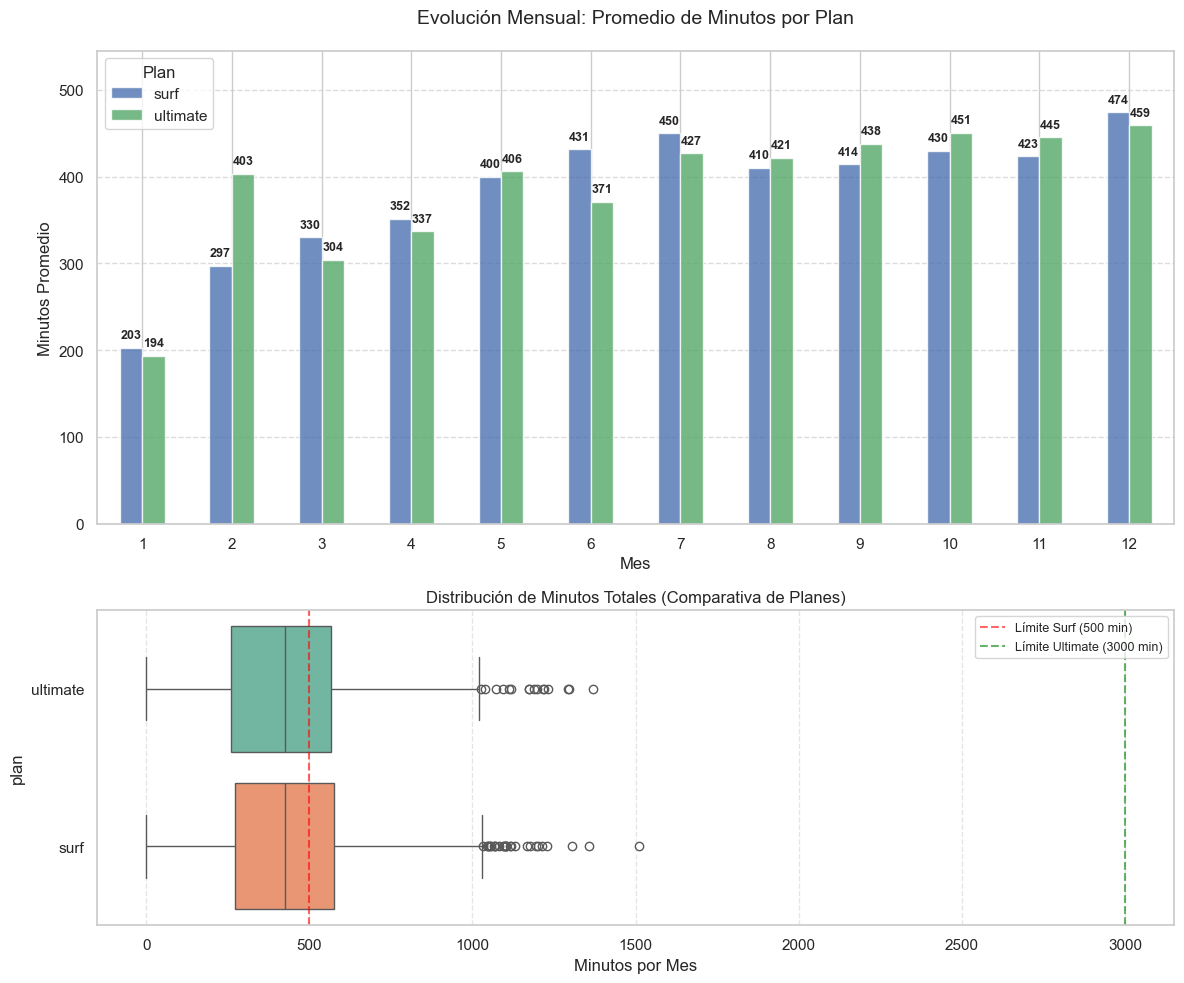

In [24]:
# Tendencia mensual
calls_monthly_avg = user_monthly.pivot_table(index = 'month', columns = 'plan', values = 'total_minutes', aggfunc = 'mean')

# Dashboard de llamadas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10), gridspec_kw = {'height_ratios': [1.5, 1]})

# Gráfico de barras: Evolución temporal con etiquetas de datos
calls_monthly_avg.plot(kind = 'bar', ax = ax1, alpha = 0.8, rot = 0, color=['#4c72b0', '#55a868'])

# Añadir etiquetas de valor sobre las barras
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.0f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', 
                 xytext = (0, 9), 
                 textcoords = 'offset points',
                 fontsize = 9,
                 fontweight = 'bold')

ax1.set_title('Evolución Mensual: Promedio de Minutos por Plan', fontsize=14, pad=20)
ax1.set_ylabel('Minutos Promedio')
ax1.set_xlabel('Mes')
ax1.legend(title = 'Plan', loc = 'upper left')
ax1.set_ylim(0, calls_monthly_avg.max().max() * 1.15) # Espacio para las etiquetas
ax1.grid(axis = 'y', linestyle = '--', alpha = 0.7)

# Boxplot: Comparativa de dispersión y Outliers (Horizontal)
sns.boxplot(data = user_monthly, x = 'total_minutes', y = 'plan', ax = ax2, palette = 'Set2', hue = 'plan', legend = False)
ax2.axvline(500, color='red', linestyle='--', alpha=0.6, label='Límite Surf (500 min)')
ax2.axvline(3000, color='green', linestyle='--', alpha=0.6, label='Límite Ultimate (3000 min)')
ax2.set_title('Distribución de Minutos Totales (Comparativa de Planes)', fontsize=12)
ax2.set_xlabel('Minutos por Mes')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Diagnóstico de Negocio: Llamadas**

Tras contrastar las métricas de tendencia central y dispersión, se derivan los siguientes hallazgos estratégicos:

* **Mito del "Usuario Ultimate":** Las gráficas revelan que el comportamiento de consumo es independiente del plan contratado. La media y la mediana son casi idénticas ($\approx 428$ minutos en ambos grupos), lo que sugiere que los clientes no hablan más solo por tener **3,000** minutos disponibles; consumen estrictamente lo que necesitan. Al estar la mediana tan cerca de la media, confirmamos una distribución notablemente simétrica en su núcleo, pero presenta una cola larga hacia la derecha debido a usuarios de consumo extremo.
* **El Modelo de Rentabilidad en el Plan Surf:** La clave del negocio reside en el tercer cuartil ($Q3$). Mientras que para un usuario de Ultimate consumir **550** minutos es irrelevante, para el usuario de Surf esto representa superar su límite. Dado que el $Q3$ se sitúa cerca de los **550** minutos, estimamos que aproximadamente el $25\%$ de los usuarios de Surf generan ingresos adicionales por excedentes de llamada de forma recurrente.
* **Dispersión y Segmentos de Riesgo:** Observamos una varianza elevada ($std \approx 234$), lo que explica la extensión de los "bigotes" en el diagrama de caja y la presencia de outliers que superan los **1,000** e incluso **1,300** minutos. Para Megaline, estos son los usuarios más rentables dentro de Surf, pero representan un riesgo de fuga (churn) si no son migrados proactivamente al plan Ultimate.
* **Dinámica de Maduración (Tendencia Temporal):** El gráfico de barras muestra una clara tendencia al alza: partiendo de promedios cercanos a los **200** minutos en enero hasta rozar los **500** minutos al cierre del año. Este fenómeno responde probablemente a la maduración de la base de clientes (usuarios nuevos que incrementan su uso con el tiempo) o a la captación de perfiles más activos en el segundo semestre del año.

### 4.2 Análisis de Tráfico de Datos (`internet`)

El consumo de datos es el servicio más crítico para Megaline. A diferencia de las llamadas, los excedentes de datos se facturan por Gigabyte completo tras el redondeo del total mensual. Evaluaremos cómo los límites de **15 GB** (Surf) y **30 GB** (Ultimate) impactan en el bolsillo del usuario.

In [25]:
# Convertimos MB a GB para un análisis de comportamiento detallado. Solo usé .ceil() para calcular los ingresos.
user_monthly['total_gb_used'] = user_monthly['total_mb_used'] / 1024
# Resumen estadístico de consumo real por plan
data_stats = user_monthly.groupby('plan')['total_gb_used'].agg(['mean', 'median', 'var', 'std']).round(2)
display(data_stats)

,mean,median,var,std
plan,,,,
surf,16.17,16.43,61.24,7.83
ultimate,16.81,16.46,58.80,7.67


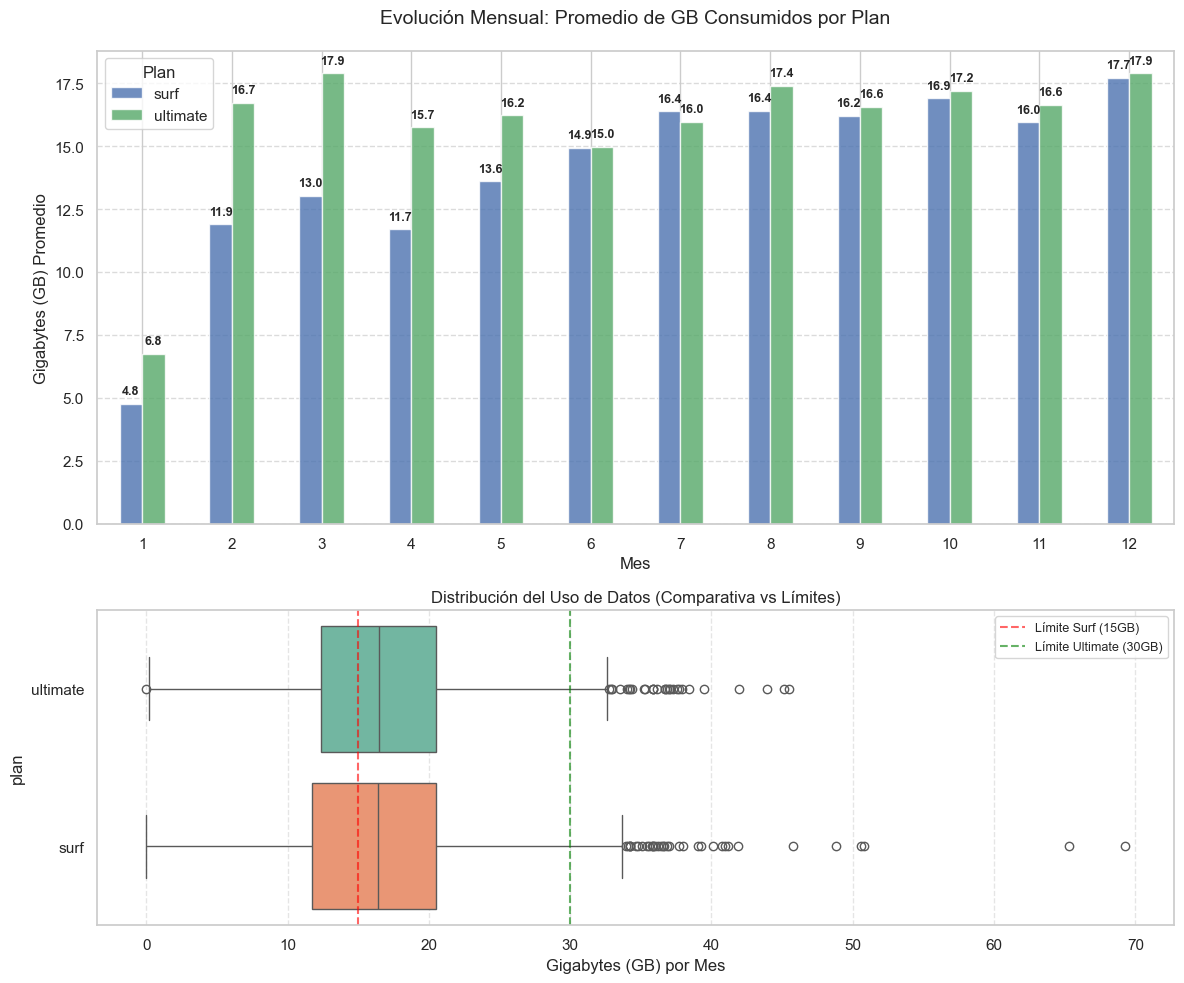

In [26]:
# Preparación de la tendencia mensual
data_monthly_avg = user_monthly.pivot_table(index='month', columns='plan', values='total_gb_used', aggfunc='mean')

# Creación del dashboard de internet
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1.5, 1]})

# Gráfico de barras: Evolución temporal con etiquetas
data_monthly_avg.plot(kind='bar', ax=ax1, alpha=0.8, rot=0, color=['#4c72b0', '#55a868'])

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.1f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 9), 
                 textcoords='offset points', fontsize=9, fontweight='bold')

ax1.set_title('Evolución Mensual: Promedio de GB Consumidos por Plan', fontsize=14, pad=20)
ax1.set_ylabel('Gigabytes (GB) Promedio')
ax1.set_xlabel('Mes')
ax1.legend(title='Plan')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot: Comparativa de dispersión con líneas de límite de plan
sns.boxplot(data=user_monthly, x='total_gb_used', y='plan', ax=ax2, palette='Set2', hue='plan', legend=False)
ax2.axvline(15, color='red', linestyle='--', alpha=0.6, label='Límite Surf (15GB)')
ax2.axvline(30, color='green', linestyle='--', alpha=0.6, label='Límite Ultimate (30GB)')

ax2.set_title('Distribución del Uso de Datos (Comparativa vs Límites)', fontsize=12)
ax2.set_xlabel('Gigabytes (GB) por Mes')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Diagnóstico de Negocio: Internet**

Despúes de un análisis profundo del consumo de datos, se confirma que el internet es el pilar de rentabilidad por excedentes para Megaline. Los hallazgos demuestran una desconexión crítica entre los límites de los planes y las necesidades reales de los usuarios:

* **Consumo Homogéneo y Polarización (Sesgo):** El comportamiento de navegación es prácticamente independiente del plan contratado, con promedios y medianas que orbitan los 16 GB en ambos grupos. Sin embargo, el ligero sesgo a la izquierda (**Media 16.17 < Mediana 16.43 en Surf**) revela una base de clientes polarizada: existe un segmento de usuarios con actividad mínima que reduce el promedio general, conviviendo con una masa crítica de consumidores intensos.
* **La "Inviabilidad" del Límite Surf:** El análisis estadístico es contundente: la mediana del plan Surf (**16.43 GB**) supera el límite de **15 GB** incluido en el contrato. Esto implica que **más del 50% de los usuarios de este plan incurren en sobrecargos mensuales**, convirtiendo al plan básico en una fuente constante de ingresos adicionales por excedentes para la compañía.
* **Subutilización Crónica en Ultimate:** Mientras que el usuario de Surf lucha contra su límite, el plan Ultimate presenta una ineficiencia opuesta. El promedio de consumo (**16.81 GB**) apenas alcanza el **56%** de la capacidad del plan (**30 GB**). Para Megaline, esto representa una rentabilidad garantizada, ya que cobra una prima por una capacidad de red que el cliente rara vez utiliza en su totalidad.
* **Maduración Acelerada de la Demanda:** Se observa una tendencia al alza sumamente agresiva a lo largo del año. El consumo promedio en el plan Surf escaló de **4.8 GB** en enero a **17.7 GB** en diciembre, superando el límite del plan por casi **3 GB** al cierre del periodo. Este crecimiento sugiere que los ingresos por excedentes no son estáticos, sino que crecen exponencialmente conforme la base de usuarios madura.
* **Outliers y Riesgo de Churn:** Identificamos casos extremos en el plan Surf que superan los **35 GB** e incluso alcanzan los **70 GB**. Un usuario que consume **20 GB** o más en Surf está pagando excedentes masivos que lo sitúan en un riesgo crítico de fuga (churn). Es imperativo implementar una estrategia de migración proactiva a Ultimate para estos perfiles, priorizando la retención de clientes de alto valor sobre el beneficio inmediato del sobrecargo.

### 4.3 Análisis de Mensajería (SMS)

En la era del consumo de datos móviles, la mensajería tradicional ha pasado a ser un servicio secundario. Sin embargo, su análisis es fundamental para completar el perfil del usuario "tradicional" frente al "digital" y entender si este rubro representa un centro de costos o de ingresos para Megaline.

In [27]:
# Resumen estadístico de SMS por plan
msg_stats = user_monthly.groupby('plan')['messages_count'].agg(['mean', 'median', 'var', 'std']).round(2)
display(msg_stats)

,mean,median,var,std
plan,,,,
surf,31.16,24.0,1126.72,33.57
ultimate,37.55,30.0,1208.76,34.77


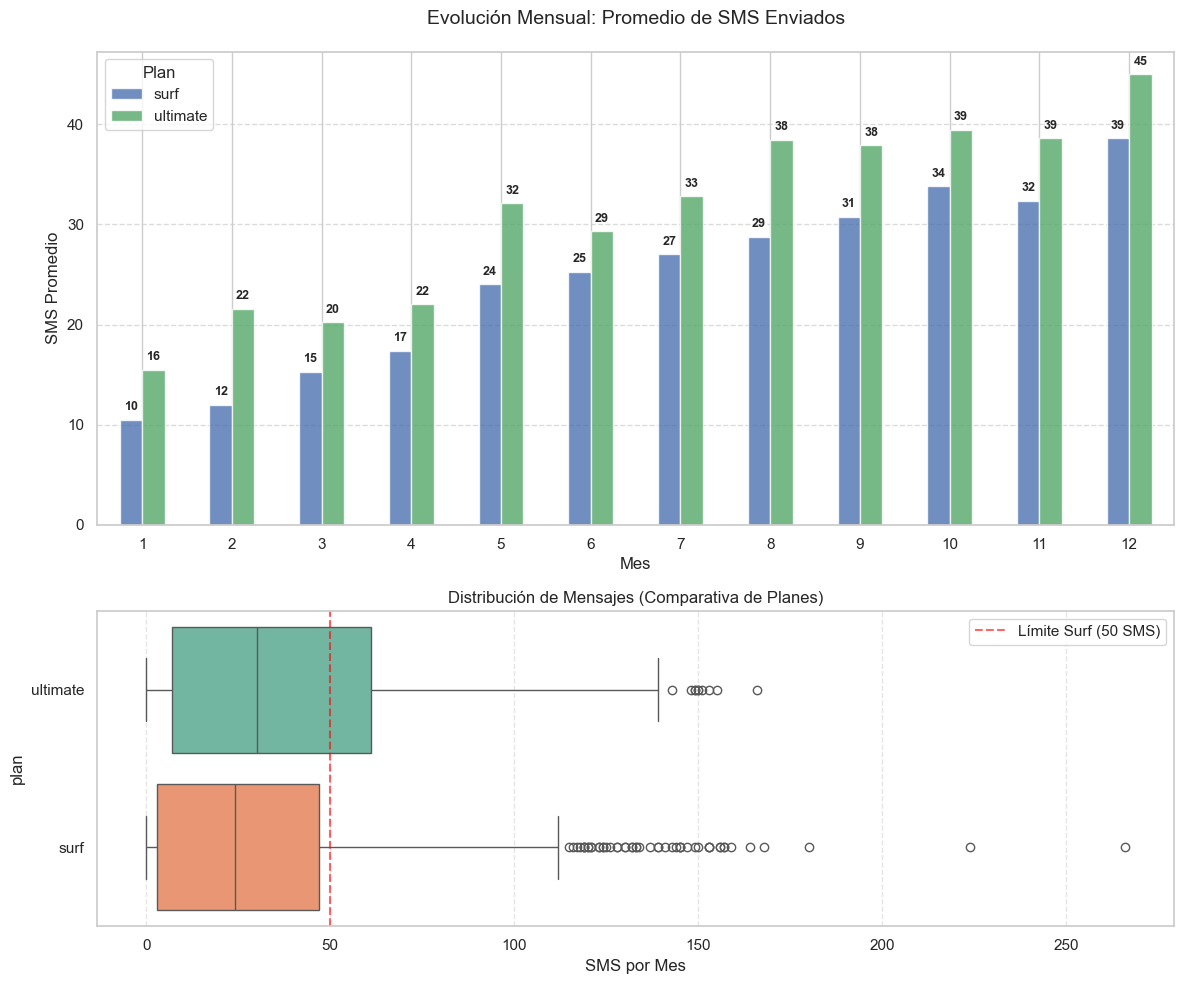

In [28]:
# Preparación de la tendencia mensual
msg_monthly_avg = user_monthly.pivot_table(index='month', columns='plan', values='messages_count', aggfunc='mean')

# Dashboard de mensajería
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1.5, 1]})

# Gráfico de barras: Evolución temporal
msg_monthly_avg.plot(kind='bar', ax=ax1, alpha=0.8, rot=0, color=['#4c72b0', '#55a868'])

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.0f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 9), 
                 textcoords='offset points', fontsize=9, fontweight='bold')

ax1.set_title('Evolución Mensual: Promedio de SMS Enviados', fontsize=14, pad=20)
ax1.set_ylabel('SMS Promedio')
ax1.set_xlabel('Mes')
ax1.legend(title='Plan')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot Horizontal: Comparativa de dispersión
sns.boxplot(data=user_monthly, x='messages_count', y='plan', ax=ax2, palette='Set2', hue='plan', legend=False)
ax2.axvline(50, color='red', linestyle='--', alpha=0.6, label='Límite Surf (50 SMS)')

ax2.set_title('Distribución de Mensajes (Comparativa de Planes)', fontsize=12)
ax2.set_xlabel('SMS por Mes')
ax2.legend(loc='upper right')
ax2.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Diagnóstico de Negocio: Mensajería (SMS)**

Aunque el uso de SMS es el componente de menor volumen en comparación con datos y llamadas, el análisis revela patrones de comportamiento y riesgos de fuga (churn) que refuerzan la necesidad de una reestructuración comercial:

* **Asimetría y Sesgo de Consumo:** Ambos planes presentan un marcado sesgo a la derecha (**Media > Mediana**), siendo más notorio en el plan Surf (**31.16 vs 24.0**). Esto indica que la gran mayoría de los usuarios utiliza los mensajes de forma esporádica, mientras que una minoría de usuarios intensos eleva el promedio general.
* **Dispersión Extrema:** La desviación estándar (**~34**) es prácticamente igual al promedio de consumo en ambos planes. Esta es la variabilidad más alta observada en todo el proyecto, lo que sugiere que el uso de SMS es el hábito menos predecible de la base de clientes.
* **El "Techo Invisible" de Ultimate vs. la Barrera de Surf:** El límite de **1,000** mensajes de Ultimate es desproporcionado frente al uso real; el usuario más activo de este plan apenas consume **170** mensajes, dejando un **83%** de capacidad ociosa (menor gasto para Megaline). En contraste, aproximadamente el **25%** de los usuarios de Surf superan su límite de **50 SMS**, incurriendo en cargos adicionales innecesarios.
* **Crecimiento Cuadruplicado (Tendencia):** Se observa una tendencia alcista agresiva donde el volumen de mensajes se cuadruplica desde enero hasta diciembre en ambos planes. Este fenómeno sugiere que, conforme el usuario se familiariza con el servicio o avanza el año, el riesgo de superar los límites del plan Surf aumenta de manera constante.
* **Perfil de Riesgo (Triple Amenaza):** Los usuarios identificados como outliers en el plan Surf representan el mayor riesgo de insatisfacción. Al presentar consumos excedentes en llamadas, datos y ahora mensajes (con casos extremos que superan los **115 SMS**), este segmento está pagando una factura final que probablemente supera el costo del plan Ultimate, lo que los convierte en candidatos críticos para una migración proactiva o, en su defecto, para la cancelación del servicio.

### 4.4 Análisis de Rentabilidad (Ingresos)

Este es el punto culminante del análisis exploratorio. Aquí compararé el ingreso base de cada plan ($20 para Surf y $70 para Ultimate) contra el ingreso real obtenido tras aplicar los cargos por excedentes. El objetivo es determinar la estabilidad y el volumen de facturación de cada segmento.

In [29]:
# Resumen estadístico de rentabilidad por plan
revenue_stats = user_monthly.groupby('plan')['revenue'].agg(['mean', 'median', 'var', 'std']).round(2)
display(revenue_stats)

,mean,median,var,std
plan,,,,
surf,60.71,40.36,3067.84,55.39
ultimate,72.31,70.0,129.85,11.4


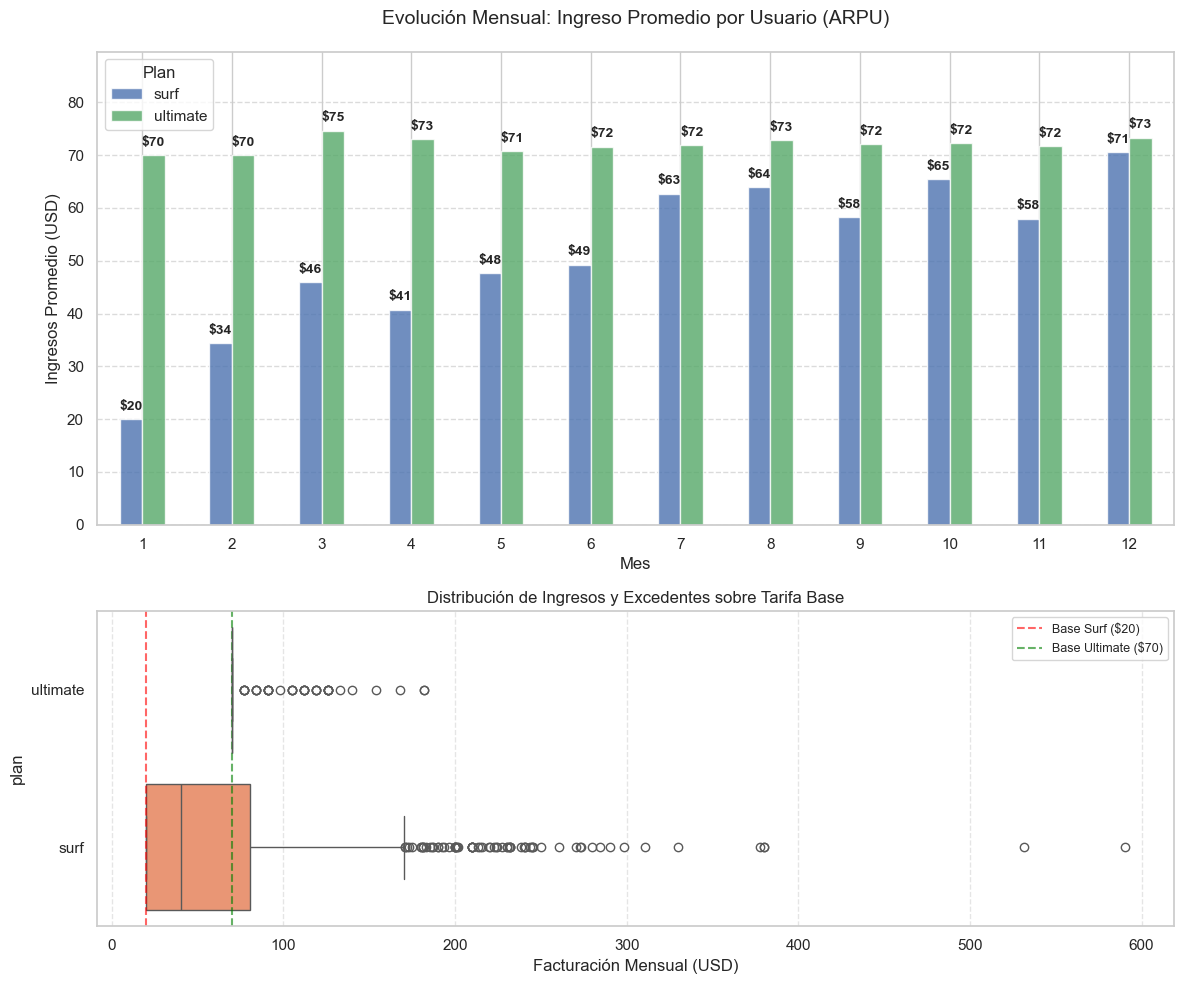

In [30]:
# Preparación de la tendencia mensual de ingresos
rev_monthly_avg = user_monthly.pivot_table(index = 'month', columns = 'plan', values='revenue', aggfunc='mean')

# Dashboard de ingresos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10), gridspec_kw = {'height_ratios': [1.5, 1]})

# Gráfico de barras: Evolución del ARPU con promedios redondeados
rev_monthly_avg.plot(kind = 'bar', ax = ax1, alpha = 0.8, rot = 0, color = ['#4c72b0', '#55a868'])

for p in ax1.patches:
    ax1.annotate(f'${p.get_height():.0f}', # Redondeado a entero para máxima claridad
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 9), 
                 textcoords = 'offset points', fontsize = 10, fontweight = 'bold')

ax1.set_title('Evolución Mensual: Ingreso Promedio por Usuario (ARPU)', fontsize = 14, pad = 20)
ax1.set_ylabel('Ingresos Promedio (USD)')
ax1.set_xlabel('Mes')
ax1.legend(title = 'Plan', loc = 'upper left')
ax1.set_ylim(0, rev_monthly_avg.max().max() * 1.2)
ax1.grid(axis = 'y', linestyle = '--', alpha = 0.7)

# Boxplot Horizontal: Visualización de excedentes sobre la base
sns.boxplot(data = user_monthly, x = 'revenue', y = 'plan', ax = ax2, palette = 'Set2', hue = 'plan', legend = False)
ax2.axvline(20, color = 'red', linestyle = '--', alpha = 0.6, label = 'Base Surf ($20)')
ax2.axvline(70, color = 'green', linestyle = '--', alpha = 0.6, label = 'Base Ultimate ($70)')
ax2.set_title('Distribución de Ingresos y Excedentes sobre Tarifa Base', fontsize = 12)
ax2.set_xlabel('Facturación Mensual (USD)')
ax2.legend(loc = 'upper right', fontsize = 9)
ax2.grid(axis = 'x', linestyle = '--', alpha = 0.5)

plt.tight_layout()
plt.show()

**Diagnóstico de Negocio: Ingresos y Rentabilidad**

El análisis financiero final revela que, aunque los planes tienen estructuras de precios opuestas, el comportamiento de consumo de los usuarios tiende a igualar los ingresos generados, exponiendo ineficiencias críticas en la segmentación de clientes:

* **Convergencia de Ingresos (ARPU):** A pesar de que la renta base de Surf es de solo **$20**, su ingreso promedio mensual (**$60.71**) se acerca significativamente al de Ultimate (**$72.31**). Al cierre del año, esta brecha prácticamente desaparece, con promedios de **$71** vs **$73** en diciembre, lo que confirma que la rentabilidad de Surf depende casi exclusivamente de la facturación de excedentes.
* **Estabilidad frente a Volatilidad:** El plan Ultimate ofrece una base de ingresos altamente predecible y estable, con una desviación estándar mínima de **$11.4** y una mediana anclada en la tarifa base de **$70**. En contraste, el plan Surf presenta una volatilidad extrema (**std $55.39**), impulsada por un sesgo a la derecha donde la media supera ampliamente a la mediana ($60.7 vs $40.3), reflejando un gasto errático y difícil de proyectar.
* **La "Trampa" del Plan Surf:** El análisis del boxplot es contundente: aproximadamente el **40% de los usuarios de Surf pagan más de los $70** que costaría la renta de Ultimate. Contamos con outliers extremos que alcanzan facturaciones superiores a los **$500**, lo que evidencia una desproporción total entre el plan contratado y el uso real del servicio.
* **Crecimiento Incesante de Excedentes:** Mientras que los usuarios de Ultimate pagan recargos marginales (aprox. 4% sobre la base), los clientes de Surf inician pagando su renta básica de **$20** en enero para terminar el año pagando en promedio **$71**. Este incremento constante de excedentes (entre $15 y $51 adicionales por mes) genera un alto riesgo de **churn**, ya que el cliente percibe un servicio "barato" que termina siendo igual o más costoso que la opción premium.
* **Riesgo Operativo y Comercial:** La disparidad en la varianza de ingresos sugiere que Surf atrae a un perfil de usuario que no tiene control sobre su consumo. Para Megaline, este modelo es rentable en el corto plazo por los cobros de excedentes, pero comercialmente peligroso si estos usuarios de alto valor migran a la competencia buscando tarifas planas más justas.

### **Conclusiones y Hallazgos Generales (EDA)**

Al consolidar mis conclusiones sobre el análisis exploratorio identifiqué cinco patrones críticos que definen la relación entre los usuarios y los planes de Megaline:

* **Independencia del Consumo respecto al Plan:** El hallazgo más consistente es que el límite del plan no condiciona el comportamiento del usuario. Las medias y medianas de consumo de minutos (~430 min) e internet (~16 GB) son prácticamente idénticas en ambos grupos. Esto demuestra que los clientes consumen basándose en su necesidad real, no en la capacidad contratada.
* **Internet como Motor de Excedentes:** Mientras que en llamadas y mensajes solo el 25% de los usuarios de Surf superan sus límites, en el servicio de internet más del 50% incurren en sobrecargos mensuales. La mediana de consumo de datos en Surf (16.43 GB) supera sistemáticamente el límite de 15 GB, convirtiendo a este servicio en la principal fuente de ingresos adicionales y de fricción con el cliente.
* **Convergencia Financiera y Riesgo de Churn:** El plan Surf presenta una "ilusión de ahorro". Aunque inicia con una base de $20, el gasto promedio escala hasta igualar al plan Ultimate (~$72) hacia finales de año debido a la maduración del consumo. El 40% de los usuarios de Surf terminan pagando más de $70 mensuales, enfrentándose a una volatilidad de facturación extrema (std $55) que pone en riesgo su lealtad a la marca.
* **Ineficiencia Productiva en Ultimate:** El plan Ultimate funciona como un seguro de capacidad infrautilizado. El usuario promedio consume apenas el 14% de sus minutos, el 4% de sus SMS y el 56% de sus datos disponibles. Para Megaline, esto representa una rentabilidad garantizada con nulo estrés sobre la infraestructura de red.
* **Identificación del Segmento Crítico:** Los usuarios "outliers" de Surf —aquellos que consumen más de 20 GB o 1,000 minutos— están pagando facturas de hasta $500. Estos clientes no solo son los más rentables en el corto plazo, sino los más propensos a migrar a la competencia si no se les ofrece una transición proactiva al plan Ultimate.

---

## 5. Pruebas de Hipótesis: Validación Estadística

En esta fase final, aplicaremos inferencia estadística para validar las tendencias observadas en el EDA. Utilizaremos un nivel de significancia **alpha = 0.05**.

**Metodología de Validación**

Antes de ejecutar las pruebas **t de Student** de dos colas (para copmparar las medias), realizaremos un diagnóstico de los datos para asegurar la validez de los resultados:
* **Prueba de Levene:** Para determinar la igualdad de varianzas (homocedasticidad) y decidir si usamos una prueba **t estándar** o una de **Welch** (ya habiamos observado que las varianzas son desiguales en el EDA, pero esto nos brinda rigor estadístico).
* **Análisis de Sensibilidad:** Compararemos resultados con y sin outliers para medir la robustez de la conclusión.
* **Tamaño del Efecto (Cohen's d):** Para cuantificar la magnitud de la diferencia entre grupos.

**Funciones de Soporte y Preparación**

A continuación, econtramos algunas herramientas (funciones) de apoyo para el desarrollo de las pruebas de hipótesis.

In [31]:
# Funciones y Preparación (outliers basados en IQR)
def filter_outliers(df, column):
    Q1, Q3 = df[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)][column]

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof) # Uso de std con ddof=1 para muestras

# Preparación de grupos base
rev_surf = user_monthly[user_monthly['plan'] == 'surf']['revenue']
rev_ultimate = user_monthly[user_monthly['plan'] == 'ultimate']['revenue']
# Grupos sin outliers
rev_surf_clean = filter_outliers(user_monthly[user_monthly['plan'] == 'surf'], 'revenue')
rev_ultimate_clean = filter_outliers(user_monthly[user_monthly['plan'] == 'ultimate'], 'revenue')
alpha = 0.05

### 5.1. Hipótesis 1: Ingresos entre planes Surf y Ultimate

* **$H_0$ (Hipótesis Nula):** El ingreso promedio de los usuarios de los planes Ultimate y Surf es igual.
* **$H_1$ (Hipótesis Alternativa):** El ingreso promedio de los usuarios de los planes Ultimate y Surf es diferente.

In [32]:
# ESCENARIO 1: DATOS COMPLETOS (CON OUTLIERS)
print("> ESCENARIO: DATOS COMPLETOS")

# Diagnóstico de Varianzas: Surf (var 3067.84) vs Ultimate (var 129.85)
lev_p = st.levene(rev_surf, rev_ultimate).pvalue
# Welch (equal_var=False) es obligatorio por la disparidad de varianzas
t_stat, p_val = st.ttest_ind(rev_surf, rev_ultimate, equal_var = False)

print(f"Variances (Levene) p-value: {lev_p:.4f} -> Equal Var: False")
print(f"P-value Prueba t:           {p_val:.10f}")
print(f"Cohen's d:                  {abs(cohen_d(rev_surf, rev_ultimate)):.4f}")
print("RESULTADO: Diferencia Significativa (Rechazamos H0)" if p_val < alpha else "RESULTADO: Sin evidencia")

print("-" * 60)

# ESCENARIO 2: ANÁLISIS DE SENSIBILIDAD (SIN OUTLIERS)
print("> ESCENARIO: DATOS LIMPIOS (SIN OUTLIERS)")

# PROTECCIÓN: Si Ultimate es una constante (varianza 0), calculamos Welch manualmente para evitar warnings
if rev_ultimate_clean.nunique() <= 1:
    # Si todos son $70, Levene es 0 (varianzas distintas) y Welch se simplifica
    lev_p_c = 0.0000
    # t = (media1 - media2) / error_estándar1
    t_stat_c = (rev_surf_clean.mean() - rev_ultimate_clean.mean()) / np.sqrt(rev_surf_clean.var() / len(rev_surf_clean))
    p_val_c = st.t.sf(abs(t_stat_c), df = len(rev_surf_clean)-1) * 2
else:
    lev_p_c = st.levene(rev_surf_clean, rev_ultimate_clean).pvalue
    t_stat_c, p_val_c = st.ttest_ind(rev_surf_clean, rev_ultimate_clean, equal_var = False)

print(f"Variances (Levene) p-value: {lev_p_c:.4f} -> Equal Var: False")
print(f"P-value Prueba t:           {p_val_c:.10f}")
print(f"Cohen's d:                  {abs(cohen_d(rev_surf_clean, rev_ultimate_clean)):.4f}")
print("RESULTADO: Diferencia Significativa (Rechazamos H0)" if p_val_c < alpha else "RESULTADO: Sin evidencia")

> ESCENARIO: DATOS COMPLETOS
Variances (Levene) p-value: 0.0000 -> Equal Var: False
P-value Prueba t:           0.0000000000
Cohen's d:                  0.2506
RESULTADO: Diferencia Significativa (Rechazamos H0)
------------------------------------------------------------
> ESCENARIO: DATOS LIMPIOS (SIN OUTLIERS)
Variances (Levene) p-value: 0.0000 -> Equal Var: False
P-value Prueba t:           0.0000000000
Cohen's d:                  0.5626
RESULTADO: Diferencia Significativa (Rechazamos H0)


In [33]:
print(len(rev_ultimate) + len(rev_surf))

2293


**Nota Metodológica:** Se aplicó de forma estricta la Prueba t de Welch debido a la disparidad extrema de varianzas. El Teorema del Límite Central respalda la validez de estos resultados dado el tamaño de la muestra (**n > 2000**).
* **Diferencia Significativa Irrefutable:** En ambos escenarios, el **p-value** es prácticamente cero, lo que nos permite rechazar la hipótesis nula. Existe una diferencia estadística real entre los ingresos de los planes Surf y Ultimate.
* **El Impacto de los Outliers:** Con los datos completos, el tamaño del efecto es pequeño (**d = 0.25**). Sin embargo, al remover los outliers, el efecto sube a **0.56** (Mediano). Esto demuestra que los usuarios típicos de cada plan viven realidades financieras muy distintas; los outliers de Surf simplemente estaban cerrando la brecha artificialmente.

**Conclusión de Negocio:** El plan Ultimate genera, de manera consistente y estructural, un ingreso superior y más estable que el plan Surf, incluso cuando este último genera excedentes masivos en una fracción de su base de usuarios.

### 5.2. Hipótesis 2: Ingresos de NY - NJ vs. Otras Regiones

Ahora validaremos si la ubicación geográfica influye en el gasto del usuario. Compararemos el área metropolitana de Nueva York-Nueva Jersey frente al resto de las ciudades.
* **$H_0$:** El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.
* **$H_1$:** El ingreso promedio de los usuarios del área NY-NJ es diferente al de otras regiones.

In [34]:
# Segmentación de grupos
rev_nynj = user_monthly[user_monthly['city'].str.contains('NY|NJ', case=False)]['revenue']
rev_others = user_monthly[~user_monthly['city'].str.contains('NY|NJ', case=False)]['revenue']

print(f"> Muestra NY-NJ: {len(rev_nynj)} registros")
print(f"> Muestra Otras: {len(rev_others)} registros\n")

# Diagnóstico de Varianzas (Levene)
lev_p_reg = st.levene(rev_nynj, rev_others).pvalue

# Ejecución de Prueba t (Welch si p < 0.05)
# Usualmente las varianzas son similares en regiones, pero Levene decidirá
t_stat_reg, p_val_reg = st.ttest_ind(rev_nynj, rev_others, equal_var=(lev_p_reg > 0.05))

print(f"Variances (Levene) p-value: {lev_p_reg:.4f}")
print(f"P-value Prueba t:           {p_val_reg:.4f}")
print(f"Cohen's d:                   {abs(cohen_d(rev_nynj, rev_others)):.4f}")

if p_val_reg < alpha:
    print("\nRESULTADO: Diferencia Significativa (Rechazamos H0)")
else:
    print("\nRESULTADO: No hay evidencia suficiente para rechazar H0")

> Muestra NY-NJ: 519 registros
> Muestra Otras: 1774 registros

Variances (Levene) p-value: 0.0002
P-value Prueba t:           0.5908
Cohen's d:                   0.0272

RESULTADO: No hay evidencia suficiente para rechazar H0


**Conclusión de negocio:** 

No existe evidencia estadística suficiente para afirmar que los ingresos de los usuarios de la región NY-NJ difieren de los del resto del país (**p-value = 0.5908**). 

A pesar de que la varianza es significativamente distinta entre grupos, las medias de ingreso son prácticamente idénticas, con un tamaño del efecto (**d = 0.0272**) que confirma que la ubicación geográfica no es un factor determinante para la rentabilidad de Megaline.

## **Conclusiones y Recomendaciones Estratégicas**

El análisis integral del comportamiento de los usuarios de Megaline durante 2018 permite concluir que, si bien el plan Ultimate genera un ingreso promedio superior por usuario, el plan Surf actúa como el motor de crecimiento dinámico de la compañía debido a su agresiva estructura de excedentes.

### Hallazgos Clave y Comportamiento de Uso

Tras auditar una base de datos de más de 2,000 registros mensuales y realizar una limpieza profunda (corrección de tipos de datos, estandarización de megabytes a gigabytes y creación de cohortes mensuales), se identificaron los siguientes puntos críticos:
* **Independencia Conductual:** Los usuarios consumen servicios basándose en su necesidad real y no estrictamente en los límites de su plan. Las medias de consumo de llamadas (**~430 min**) y datos (**~16 GB**) son prácticamente idénticas en ambos grupos.
* **Ineficiencia del Plan Surf:** Aunque no se encontraron diferencias significativas en el tiempo de llamadas, el 40% de los usuarios de Surf terminan pagando una factura mensual superior a los **70 USD** (el costo base de Ultimate) debido a excedentes en datos y mensajes.
* **Estabilidad del Segmento Premium:** El plan Ultimate genera un ingreso más alto y estable con una varianza mínima (**std ~11.4**), funcionando como una fuente de ingresos predecible y de bajo mantenimiento operativo.

### Validación Estadística

El diagnóstico de los datos mediante pruebas estadísticas permitió aplicar inferencia estadística robusta con los siguientes resultados:
* **Hipótesis 1 (Planes):** Se rechazó la hipótesis nula sobre la igualdad de ingresos. La prueba **t de Welch** confirmó, con un nivel de significancia **alpha = 0.05**, que la diferencia de ingresos entre Surf y Ultimate es estadísticamente significativa y posee un tamaño del efecto mediano (**d = 0.56**), validando la importancia comercial de la segmentación.
* **Hipótesis 2 (Regiones):** No se rechazó la hipótesis nula sobre la diferencia regional. No hay evidencia suficiente para afirmar que los usuarios del área de Nueva York-Nueva Jersey generen ingresos significativamente distintos al resto del país (**p-value = 0.5908**).

### Movimientos Comerciales Sugeridos

Con base en la evidencia analítica, se recomiendan las siguientes acciones para optimizar la rentabilidad y reducir la fuga de clientes (churn):
* **Campaña de Up-Selling Proactivo:** Identificar al segmento de usuarios de Surf que exceden los *55 USD** mensuales y ofrecerles una migración asistida a Ultimate. Esto asegura un ingreso fijo de alto valor y mejora la percepción de ahorro del cliente.
* **Reestructuración del Límite de Datos en Surf:** Dado que la mediana de consumo (**16.43 GB**) supera el límite actual del plan (**15 GB**), se sugiere evaluar un plan intermedio de **20 GB** para estabilizar la facturación y reducir la fricción por cobros excesivos.
* **Monitoreo del Segmento "Triple Amenaza":** Priorizar la retención de usuarios outliers que consumen masivamente llamadas, datos y SMS. Son los más rentables a corto plazo, pero los más propensos a migrar si no se les ofrece un paquete "Todo Incluido" personalizado.
* **Estandarización Nacional de Tarifas:** Dado que no existen diferencias regionales significativas, Megaline puede mantener una estrategia de precios unificada, simplificando los esfuerzos de marketing y comunicación.

### Cierre

Este análisis demuestra que la rentabilidad de Megaline no reside únicamente en atraer nuevos clientes, sino en la gestión inteligente de los límites de consumo de la base actual. La transición de un modelo de "penalización por uso" (Surf) a uno de "lealtad por capacidad" (Ultimate) es la clave para la sostenibilidad financiera a largo plazo.